# Video pipeline with Yolo + Resnet Model

In [366]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [367]:
metaserieses = [24]
serieses = [31]

series_names = None
# series_names = {
#     # 1: "IPA-accuracy",
#     2: "IPA",
#     # 3: "IPA-cost",
#     4: "FA2-high",
#     # 5: "FA2-high",
#     # 6: "RIM-low",
#     7: "RIM-high",
# }

series_paths = {
series: os.path.join(FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series))
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [368]:
series_paths

{31: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/24/series/31'}

In [369]:
loaders

{31: <experiments.utils.parser.AdaptationParser at 0x7f52e3f7f670>}

In [370]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 31 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': 'scale',
    'batching_cap': 1,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 20,
    'from_storage': [False, True],
    'gamma': 1e-06,
    'initial_active_model': [   'facebook-s2t-large-librispeech-asr',
                                'deepset-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [6, 2],
    'latency_margin': 100,
    'logs_enabled': False,
    'metadata': 'bursty - fa2-high - cpu type: compute_cascadelake_r_ib - redo '
                'of metaseries bursty on chameleon to check latencies',
    'metaseries': 24,
    'mode': 'exponential',
    'model_name': ['audio', 'nlp-qa'],
    'monitoring_

In [371]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [372]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{31: False}

In [373]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [374]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

[29, 30, 30, 30, 28, 32, 29, 30, 31, 28, 26, 28, 29, 27, 30, 28, 26, 29, 26, 29, 27, 27, 32, 33, 28, 28, 30, 30, 31, 28, 27, 28, 28, 29, 31, 33, 29, 24, 31, 30, 30, 27, 30, 26, 29, 29, 31, 26, 25, 29, 29, 28, 27, 32, 31, 29, 26, 28, 33, 29, 31, 30, 29, 29, 30, 31, 32, 29, 31, 29, 30, 29, 26, 29, 30, 31, 30, 31, 27, 27, 26, 30, 25, 33, 27, 32, 28, 30, 29, 27, 25, 28, 31, 29, 29, 28, 26, 31, 30, 28, 32, 25, 30, 27, 30, 28, 30, 29, 27, 27, 29, 29, 31, 28, 27, 28, 28, 29, 28, 27, 32, 29, 28, 30, 30, 29, 29, 29, 27, 32, 28, 28, 33, 28, 29, 29, 28, 29, 30, 30, 28, 26, 29, 29, 28, 26, 29, 31, 29, 28, 29, 28, 26, 33, 28, 32, 29, 28, 28, 33, 28, 30, 28, 28, 30, 25, 27, 28, 30, 28, 31, 26, 29, 29, 27, 30, 29, 28, 27, 30, 30, 26, 32, 32, 26, 29, 31, 31, 31, 30, 26, 29, 28, 28, 27, 34, 28, 29, 31, 29, 30, 30, 28, 31, 29, 30, 26, 29, 30, 31, 30, 31, 34, 28, 29, 31, 32, 30, 28, 29, 32, 27, 29, 27, 31, 30, 28, 28, 27, 30, 28, 28, 28, 29, 30, 28, 31, 32, 30, 31, 31, 28, 25, 31, 27, 26, 30, 28, 26, 30,

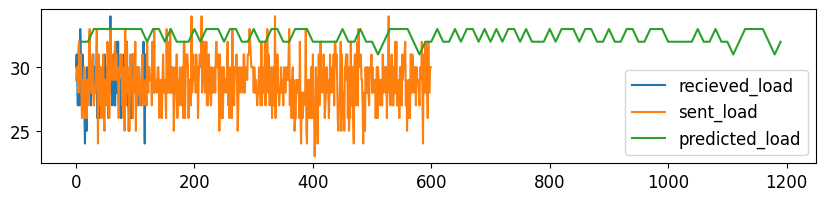

In [375]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()

    # print(50 * "-" + f" {series} " + 50 * "-")
    # recieved_load = series_changes[series]["recieved_load"]
    # # recieved_load = [int(item) for item in recieved_load if item != 0]
    # recieved_load_x = [x for x in range(0, len(recieved_load))]
    # sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    # print(sent_loads[series])
    # print(recieved_load)

    # print(len(sent_loads[series]))
    # print(len(recieved_load))
    # plt.figure(figsize=(10, 2))
    # plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    # plt.plot(sent_load_x, sent_loads[series], label="sent_workload")
    # # TODO add predicted reference load here
    # plt.legend()
    # plt.show()

## Replica Changes
1. Total
2. Per node

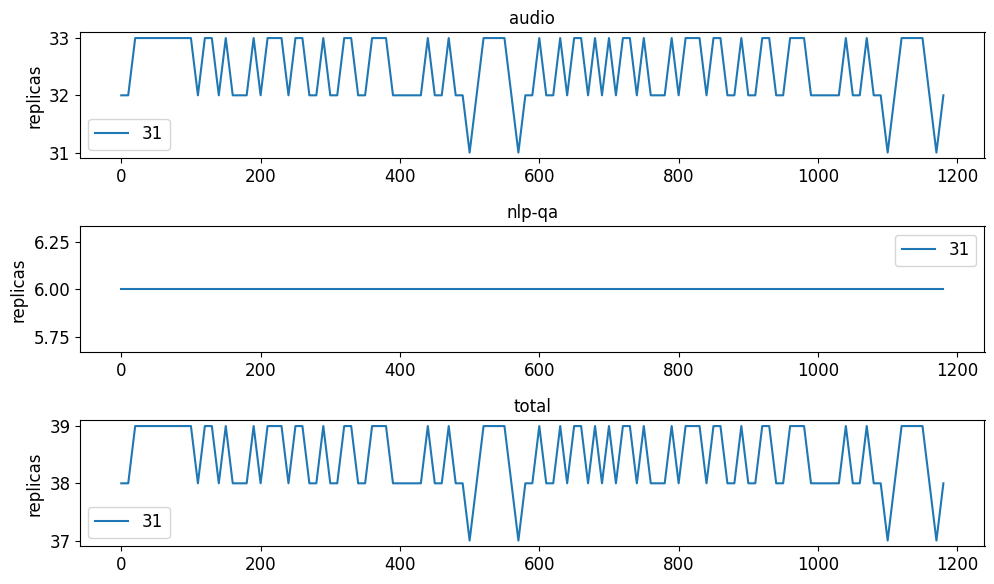

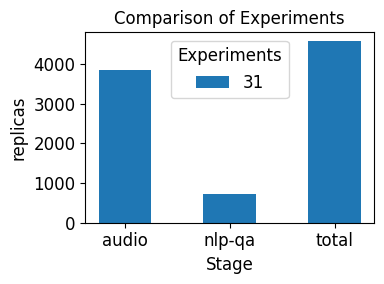

In [376]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
ylabel = "replicas"
draw_temporal(
    replica_changes, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
)
draw_cumulative(replica_changes, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

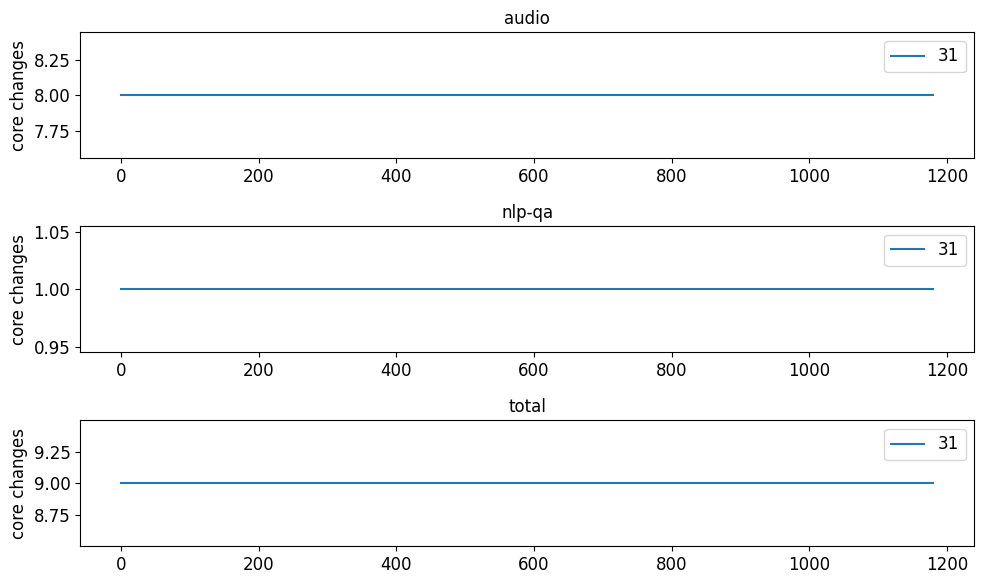

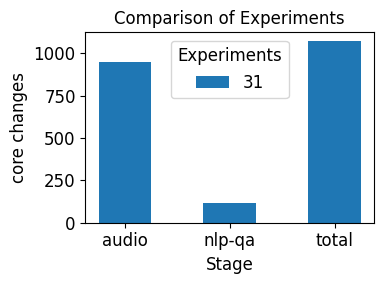

In [377]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
draw_temporal(
    core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)

draw_cumulative(
    core_changes, multiple_experiments=True, ylabel=ylabel, series_names=series_names
)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

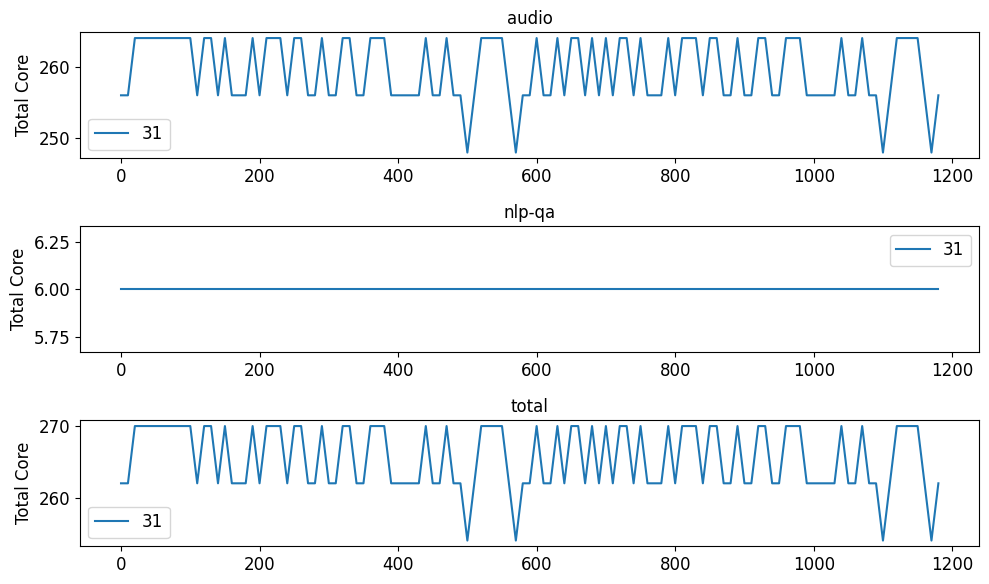

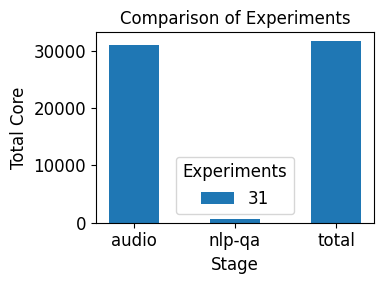

In [378]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
draw_temporal(
    total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(
    total_core_changes,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Accuracy Changes

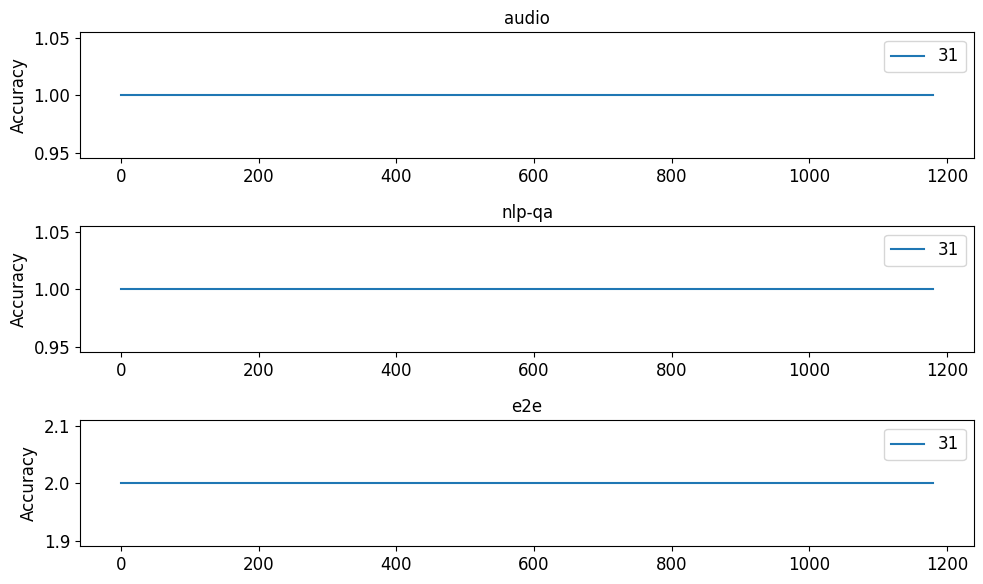

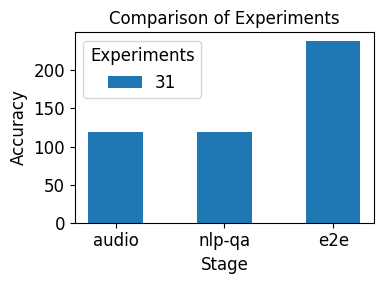

In [379]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    # draw_temporal(accuracy_changes[series])
ylabel = "Accuracy"
draw_temporal(
    accuracy_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(
    accuracy_changes,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Batching Changes

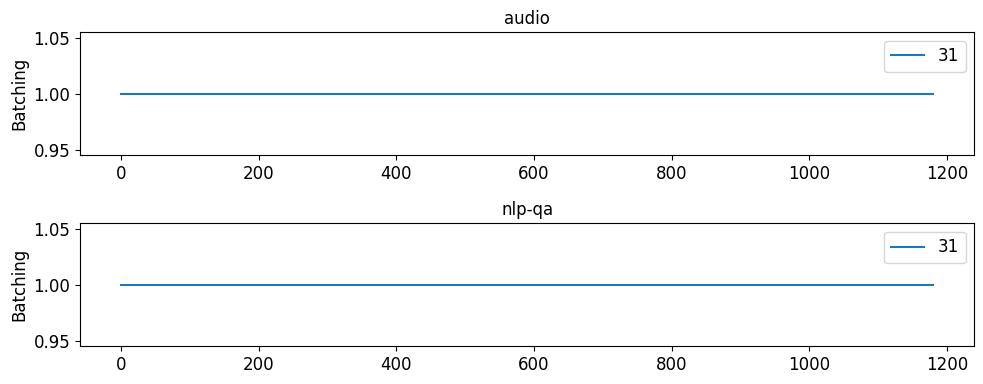

In [380]:
batching_changes = {}
for series in serieses:
    batching_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        batching_changes[series][node_name] = metrics["batch"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    # batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
    # draw_temporal(batching_changes[series])
ylabel = "Batching"
draw_temporal(
    batching_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(batching_changes, multiple_experiments=True, ylabel=ylabel)

# Expected Throughput

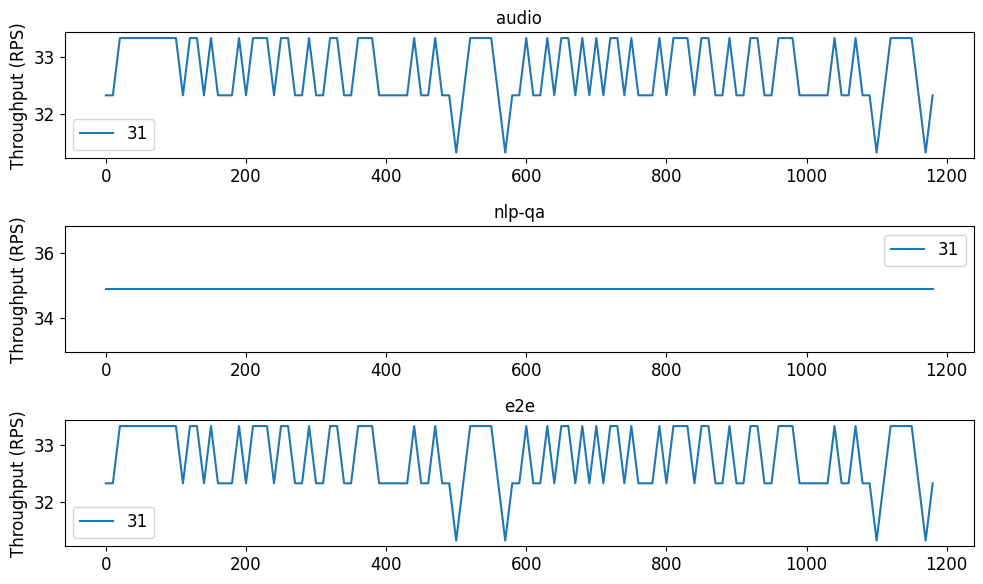

In [381]:
throughput_changes = {}
for series in serieses:
    throughput_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        throughput_changes[series][node_name] = metrics["throughput"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    throughput_changes[series]["e2e"] = [
        min(x) for x in zip(*throughput_changes[series].values())
    ]
    # draw_temporal(throughput_changes[series])
ylabel = "Throughput (RPS)"
draw_temporal(
    throughput_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(throughput_changes, multiple_experiments=True, ylabel=ylabel)

## Expected Latency

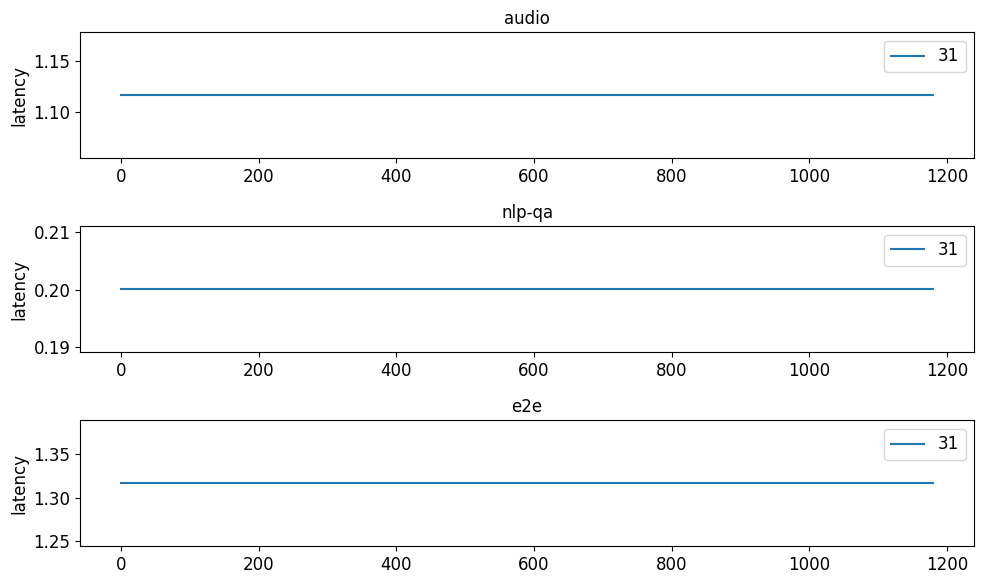

In [382]:
latency_changes = {}
for series in serieses:
    latency_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        latency_changes[series][node_name] = metrics["latency"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    latency_changes[series]["e2e"] = [
        sum(x) for x in zip(*latency_changes[series].values())
    ]
    # draw_temporal(latency_changes[series])
ylabel = "latency"
draw_temporal(
    latency_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(latency_changes, multiple_experiments=True, ylabel=ylabel)

# Real Latencies

## Maeseured p99 Latency


In [383]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_187940/3652332859.py", line 5, in <module>
    timeout_per_second[series], per_second_results[series] = loaders[
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 543, in per_second_result_processing
    return self.loader.per_second_result_processing()
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 474, in per_second_result_processing
    results = self._read_results(selected)
  File "/home/cc/infernece-pipeline-joint-optimization/experiments/utils/parser.py", line 103, in _read_results
    json_file = open(full_path)
FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/24/series/31/0.json

In [384]:
if not all(simulation_modes.values()):
    metric = "p99"  # [min, max, p99]
    metrics_all = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            metric_columns = list(
                filter(lambda col: metric in col, per_second_results[series].columns)
            )
            metrics_all[series] = per_second_results[series][metric_columns]
            # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
            metrics_all[series] = metrics_all[series].to_dict(orient="list")
            # draw_temporal(metrics_all[series])
    ylabel = "Second"
    draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
    # draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

KeyError: 31

# Every point a change was triggered

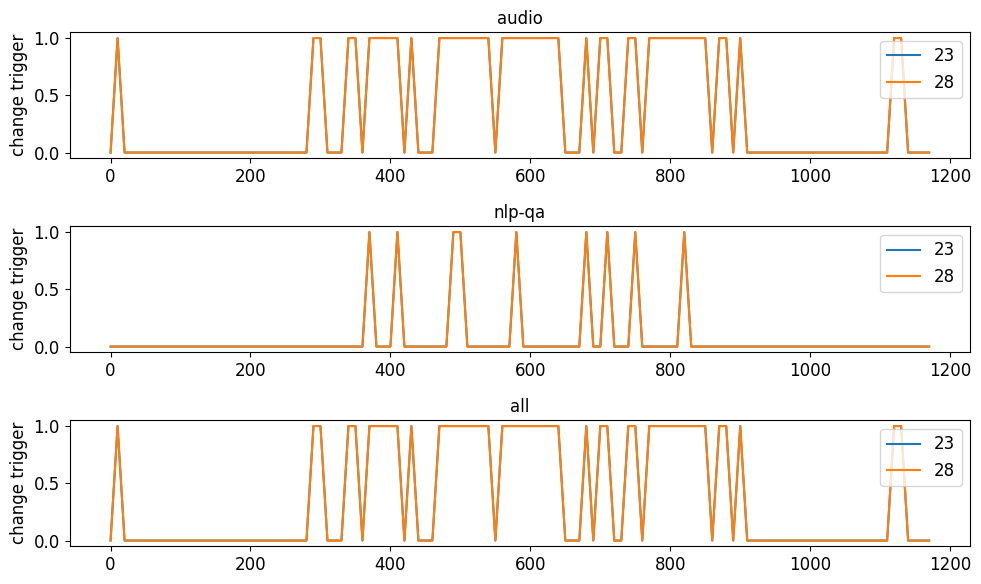

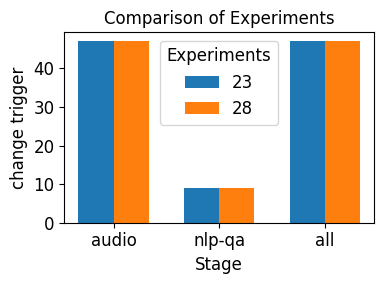

In [ ]:
change_trigger = {}
for series in serieses:
    change_trigger[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    change_trigger[series] = loader.points_with_change(
        adaptation_log=adaptation_logs[series]
    )
    change_trigger[series]["all"] = [
        any(x) for x in zip(*change_trigger[series].values())
    ]
    # draw_temporal(change_trigger[series], adaptation_interval=adaptation_intervals[series])
ylabel = "change trigger"
draw_temporal(
    change_trigger, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(change_trigger, multiple_experiments=True, ylabel=ylabel)

# Changes in the objective

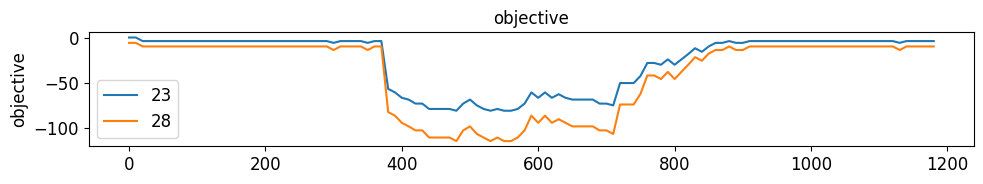

In [ ]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["objective"] = series_changes[series]["objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "objective"
draw_temporal(
    objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

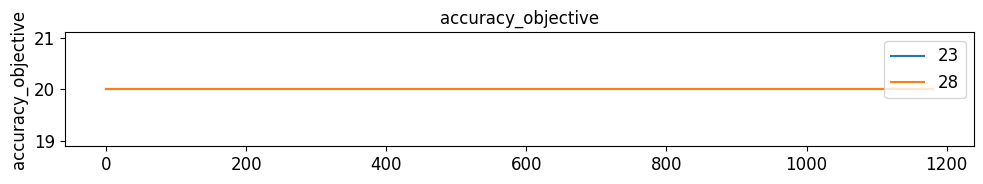

In [ ]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["accuracy_objective"] = series_changes[series]["accuracy_objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "accuracy_objective"
draw_temporal(
    objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

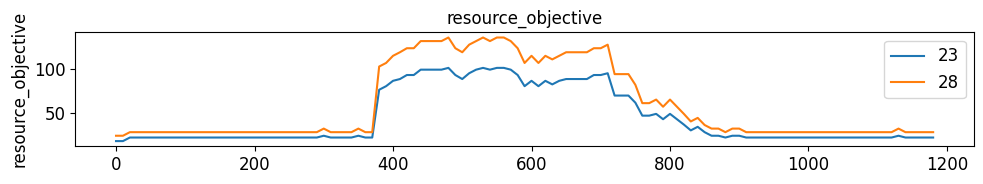

In [ ]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["resource_objective"] = series_changes[series]["resource_objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "resource_objective"
draw_temporal(
    objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

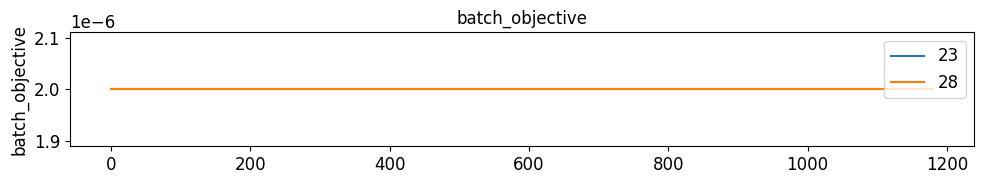

In [ ]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["batch_objective"] = series_changes[series]["batch_objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "batch_objective"
draw_temporal(
    objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

## timeouts

In [ ]:
import numpy as np

if not all(simulation_modes.values()):
    ylabel = "% SLA Violations"
    xlabel = "Experiments"
    timeout_dics = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            timeout_dics[series] = {
                "": (
                    np.array(timeout_per_second[series]) / sum(sent_loads[series])
                ).tolist()
            }
            # draw_temporal(timeout_dics[series])
            print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")
    draw_temporal(timeout_dics, multiple_experiments=True, ylabel=ylabel)
    draw_cumulative(
        timeout_dics,
        multiple_experiments=True,
        ylabel=ylabel,
        series_names=series_names,
        xlabel=xlabel,
    )

In [ ]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node: {node_name}\n")
                for config_name, config_values in all_configs.items():
                    print(f"{config_name}: {config_values}")

-------------------------------------------------- 23 --------------------------------------------------
node: audio

cpu: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
replicas: [9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 11, 11, 11, 11, 12, 11, 11, 37, 39, 42, 43, 45, 45, 48, 48, 48, 48, 49, 45, 43, 46, 48, 49, 48, 49, 49, 48, 45, 39, 42, 39, 42, 40, 42, 43, 43, 43, 43, 45, 45, 46, 34, 34, 34, 30, 23, 23, 24, 21, 24, 21, 18, 15, 17, 14, 12, 12, 11, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 11, 11, 11, 11, 11]
batch: [1, 1, 1, 1, 1, 1, 1, 1, 1,